In [0]:
import os
import cv2
from google.colab.patches import cv2_imshow
from time import time
from tqdm import tqdm 

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from fastai.vision import *
from fastai import *

import pickle

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
mypath = 'fellowshipai-data/jeffrey/video_challenge'
sys.path.append('/content/gdrive'+mypath)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

gradcam_id = '1zHuSijmfDKcGne0mRS9cKZGp5QXUl84v'
downloaded = drive.CreateFile({'id':gradcam_id})    
downloaded.GetContentFile('gradcam.py')

from gradcam import GradCam
# credit for gradcam class goes to:
# https://github.com/anhquan0412/animation-classification/blob/master/gradcam.py


In [10]:
class Video:
    
    def __init__(self):
        
        # store learner .pkl filename : pretrained cnn_learner
        self.learners = {} 

        
    def video_to_frames(self,filepath,vid_fname,dest,verbose=False):
        '''
        convert mp4 video file to jpg frames
        filepath    : path cwd, str
        vid_fname   : filename of mp4 to process, str
        dest        : destination folder to create, str
        verbose     : whether to print processing status, bool 
        '''
        print(filepath+vid_fname)
        # Playing video from file:
        cap = cv2.VideoCapture(filepath+vid_fname)
        
        try:
            path = filepath+dest
            if not os.path.exists(path):
                print('adding:\n'.format(path))
                os.mkdir(path)
        except OSError:
            print ('Error: Creating directory of data')

        # get total frames in cv2 object
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('total frames:',n_frames)
        currentFrame = 0
        for i in tqdm(range(n_frames)):     
            # Capture frame-by-frame
            ret, frame = cap.read()

            # Saves image of the current frame in jpg file
            name = path+'/frame' + str(currentFrame) + '.jpg'
            if verbose:
                print ('Creating...' + name)
            cv2.imwrite(name, frame)

            # To stop duplicate images
            currentFrame += 1

        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
        print('\n{} converted to .jpg frames in:\n{}'.format(vid_fname,filepath+dest))
        

    def learner_predictions(self,file_path):
        '''
        for each learner in self.learners, make predictions on each jpg frame in 
        file_path+frame_folder and save the predictions in a dictionary 
        as learner_name key : list of prediction list, classes values
        file_path    : base_dir, str
        returns      : dict of dict 
        '''
        t0 = time()
        print('\ncomputing predictions for each learner in self.learners in:\n{}\n'.format(file_path))
        root,dirs,files = next(os.walk(file_path))
        # must sort filenames else files in order file0, file1, file 10,..
        files = self.sort_filenames(files)
        # init storage for learer predictions 
        from collections import OrderedDict, defaultdict
        result_dict = OrderedDict()
        learn_pred_dict = defaultdict(dict)

        # iterate over all frames in path/folder    
        for i in tqdm(range(len(files))):
            img_pth = root+'/'+files[i] 
            # fastai open_image for compatible image object in predict method
            try:
                img = open_image(img_pth)
            except OSError as err:
                print(err)
                pass

            # for each image, obtain predictions for each learner
            for learn_key in self.learners:
                learn = self.learners[learn_key]
                data = learn.data

                torch_pred = learn.predict(img)
                predlist = (torch_pred[2]).tolist()

                # get prediction
                ix_argmax = np.argmax(predlist)
                max_proba = predlist[ix_argmax]
                pred_class = data.classes[ix_argmax]

                # store learner i predictions and classes
                if files[i] in result_dict:
                    result_dict[files[i]].update({learn_key:[[max_proba,pred_class],predlist,data.classes]})
                else:
                    result_dict[files[i]] = {learn_key:[[max_proba,pred_class],predlist,data.classes]}
        
        print('\npredictions stored for frames in {}\n'.format(file_path))
        mins = (time()-t0)/60
        print('\nRuntime: {:.2f} mins'.format(mins))
        return result_dict 

    
    def frames_to_video(self,path,frames_folder,fname_out,
                        pred_dict,
                        fontsz=1,rgb_list=[(255,255,255),(0,255,0)],thickness=1,
                        fps=10,show_proba=True,threshold=None):
        '''
        converts jpg frames to avi video
        # https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481
        path          : full path to cwd, str
        frames_folder : name of folder where jpg frames are stored, str
        fname_out     : file name of output .avi video, str
        pred_dict     : hash of cnn_name: pretrained cnn_leaner,ImageDataBunch
        fontsz        : font size of text overlay, float
        rgb           : color of text and rectangle, tuple of int
        thickness     : text and rectangle linewidth, int
        fps           : frames per sec, float 
        show_proba    : annotate prediction proba, bool
        threshold     : prediction proba threshold to overlay text, float
        returns       : None
        '''
        t0 = time()
        from os.path import isfile, join

        root,dirs,files = next(os.walk(path+frames_folder))
        # must sort filenames else files in order file0, file1, file 10,..
        files = self.sort_filenames(files)
    
        print('\nReading .jpg frames in: {}'.format(path+frames_folder))

        pathIn= path+frames_folder 
        pathOut = path+fname_out
        fps = fps
        frame_array = []
        file_name_list = [root+'/'+files[i] for i in range(len(files))]
        for i in tqdm(range(len(file_name_list))):
            img = cv2.imread(file_name_list[i]) # .jpg
            im_arr = np.asarray(img) # convert to np array  
            fastai_image = open_image(file_name_list[i]) 

            # add prediction text annotation
            for j,(learner_name,rgb) in enumerate(zip(pred_dict[files[i]],rgb_list)): # dict of dict with learner name key
                pred_result = pred_dict[files[i]][learner_name][0]
                pred_proba,pred_class = pred_result[0],pred_result[1]
                r,g,b = rgb[0],rgb[1],rgb[2]
                if threshold:
                    # show when above thresh
                    if pred_proba >= threshold:
                        if show_proba:
                            s='{} {:.3f}'.format(pred_class.upper(),pred_proba)
                        else:    
                            s='{}'.format(pred_class.upper())
                        # only show bbox if > thresh    
                        tmp_img,bb_coord = self.bbox(learner_name,im_arr,fastai_image,pred_class,
                                           blur=False,thresh_pad=20,
                                           rgb=(0,0,0),linewidth=thickness*6) # black background
                        tmp_img,bb_coord = self.bbox(learner_name,im_arr,fastai_image,pred_class,
                                           blur=False,thresh_pad=20,
                                           rgb=(r,g,b),linewidth=thickness*2) # rgb foreground
                        x,y,w,h = bb_coord
                        tmp_img = self.overlay_text(im_arr,s,coord=(x+15,y+30),
                                             font=cv2.FONT_HERSHEY_SIMPLEX,
                                             fontsz=fontsz,rgb=(0,0,0),thickness=thickness*3)  
                        tmp_img = self.overlay_text(im_arr,s,coord=(x+15,y+30),
                                             font=cv2.FONT_HERSHEY_SIMPLEX,
                                             fontsz=fontsz,rgb=(r,g,b),thickness=thickness*2)  
                    # case when proba<threshold, keep original image    
                    else:
                        tmp_img = im_arr
                        
                # always show bbox and class label       
                else:      
                    if show_proba:
                        s='{} {:.3f}'.format(pred_class.upper(),pred_proba)
                    else:
                        s='{}'.format(pred_class.upper())
                        
                    tmp_img,bb_coord = self.bbox(learner_name,im_arr,fastai_image,pred_class,
                                       blur=False,thresh_pad=20,
                                       rgb=(0,0,0),linewidth=thickness*6) # black background
                    tmp_img,bb_coord = self.bbox(learner_name,im_arr,fastai_image,pred_class,
                                       blur=False,thresh_pad=20,
                                       rgb=(r,g,b),linewidth=thickness*2) # rgb foreground
                    x,y,w,h = bb_coord
                    tmp_img = self.overlay_text(im_arr,s,coord=(x+15,y+30),
                                         font=cv2.FONT_HERSHEY_SIMPLEX,
                                         fontsz=fontsz,rgb=(0,0,0),thickness=thickness*3)  
                    tmp_img = self.overlay_text(im_arr,s,coord=(x+15,y+30),
                                         font=cv2.FONT_HERSHEY_SIMPLEX,
                                         fontsz=fontsz,rgb=(r,g,b),thickness=thickness*2)  
                        
            height, width, layers = tmp_img.shape
            size = (width,height)

            #insert frame into an image array
            frame_array.append(tmp_img)

        out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
        for i in range(len(frame_array)):
            # writing to a image array
            out.write(frame_array[i])
        out.release()
        
        mins = (time()-t0)/60
        print('\nRuntime: {:.2f} mins'.format(mins))
        
        print('\n.jpg frames to .avi video conversion complete for images in {}\n'.format(path+frames_folder))

    def overlay_text(self,img_arr,text_str,coord=(50,75),
                     font=cv2.FONT_HERSHEY_SIMPLEX,
                     fontsz=2,rgb=(255,255,255),thickness=2):
        '''
        overlay text to an image array
        img_arr    : image, np.array
        text_str   : value to write, str
        coord      : loc of text, tuple of int
        font       : cv2 specified font
        fontsz     : fontScale of text, int
        rgb        : red,green,blue code, tuple
        thickness  : thickness of font, int
        returns    : image, jpg
        '''
        #black background
        img = cv2.putText(img_arr,text_str,coord,font,fontsz,
                          (0,0,0),thickness+3)
        # parameterized rgb overlay
        img = cv2.putText(img_arr,text_str,coord,font,fontsz,
                          rgb,thickness)  
        return img

    def bbox(self,learner_name,arr_im,fastai_img,label,
             blur=False,thresh_pad=10,
             rgb=(255,255,0),linewidth=1):
        '''
        compute gradcam saliency map attention (sm) and boundingbox around sm
        learner_name : name of pretrained cnn object, fastai cnn_learner
        arr_im       : image pixel data, numpy array
        fastai_img   : image object for gradcam, fastai Image 
        label        : predicted class label from learner, str
        blur         : applies medianBlur to saliency map, bool
        thresh_pad   : adds a scalaer to cv2 binary threshold, int 
        rgb          : rgb code, (r,g,b) tuple of ints
        linewidth    : bbox line width, float
        returns      : bounding box coordinates and image array with bounding box
        '''
        # compute gradcam attention/saliency map object
        orig_im = arr_im
        learner = self.learners[learner_name]
        gcam = GradCam.from_one_img(learner,fastai_img)
        # compute heatmap
        hmap = gcam.hmap1  

        # resize reduced heatmap array to match original image 
        dim = orig_im.shape
        xdim,ydim = dim[1],dim[0]
        hmap = cv2.resize(hmap,(xdim,ydim))

        # normalize sm with image
        hnorm = None
        hnorm  = cv2.normalize(hmap,hnorm,alpha=0,beta=255,
                               norm_type=cv2.NORM_MINMAX)
        hnorm  = np.array(hnorm,dtype=np.uint8)
        hnorm = cv2.applyColorMap(hnorm,cv2.COLORMAP_JET)
        if blur:
            hnorm = cv2.medianBlur(hnorm,15)

        # must convert to grayscale before passing data to findContours 
        hnorm_gray = cv2.cvtColor(hnorm,cv2.COLOR_BGR2GRAY)
        # must make it an array
        hnorm_gray = np.array(hnorm_gray,dtype=np.uint8)
        # compute binary threshold array
        min_val = hnorm_gray.min()
        ret,thresh = cv2.threshold(hnorm_gray,min_val+thresh_pad,255,
                                   cv2.THRESH_BINARY)
        im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
        cnt = contours[0]

        # get rectangle bounding box vertices x,y, width w, height h
        x,y,w,h = cv2.boundingRect(cnt) 
        # draw rectangle on original image
        cv2.rectangle(orig_im,(x,y),(x+w,y+h),rgb,linewidth) # black back
        
        # cv2_imshow(orig_im)
        return orig_im, (x,y,w,h)
    
    @staticmethod
    def learner_max_pred(learner_pred_dict,learner_key):
        '''
        get class with argmax proba from 
        dict of learner key : list of probas,classes values
        learner_red_dict : dict of learner key : list of probas, classes, dict 
        dictkey          : model name key in frame learner pred dict, str
        learner_key      : name of learner in self.learners, str
        returns          : tuple of class label, max pred proba 
        '''
        predlist = learner_pred_dict[learner_key][0]
        classes = learner_pred_dict[learner_key][1]
        ix_argmax = np.argmax(predlist)
        class_pred = classes[ix_argmax]
        max_proba = predlist[ix_argmax]
        return class_pred,max_proba
    
    @staticmethod
    def sort_filenames(fname_list):
        '''
        sorts strings (file names) in a list where we have unsorted
        [frame0.jpg,frame1.jpg,frame10.jpg,...] so that frames wlll 
        be processed in ascending order
        fname_list    : file names to sort, list of str
        returns       : list
        '''
        from tkinter import Tcl
        lst = Tcl().call('lsort', '-dict', fname_list)
        return lst
    
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner,weights:torch.Tensor=None):
        super().__init__(learn)
        self.weights = weights
    def on_train_begin(self, **kwargs):
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels,return_counts=True)
        if self.weights is None: self.weights = torch.DoubleTensor((1/counts)[self.labels]) 
        self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
        self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)

__all__ = ['OverSamplingCallback']


v = Video()

root_dir = "/content/gdrive/My Drive/"
dir = 'fellowshipai-data/jeffrey/video_challenge/'
cwd = root_dir + dir
cwd


'/content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/'

### Load Pretrained `cnn_learner`s
- doneness and raw foods models
- raw group's model requires OverSamplingCallback 
- store dict of `cnn_learner pkl` filename as key : pretrained `cnn_learner` object as values  

In [0]:
model_path = cwd+'/models' 
saved_models = ['rn34_base_jeff.pkl','nyc_raw_food.pkl']

v.learners = {model_name:load_learner(model_path,model_name) for model_name in saved_models}
# v.learners

### Transform .mp4 video to .jpg 
`video_to_frames` method processes an `.mp4` in Google Drive cwd and makes a new folder to store `jpg` files as output

In [0]:
# v.video_to_frames(base_dir,'SteakAvo.mp4','steak_avo',verbose=False)
# v.video_to_frames(base_dir,'SteakAvo.mp4','steak_avo',verbose=False)
# v.video_to_frames(cwd,'Chicken - 11679.mp4','chicken_11679',verbose=False)
# v.video_to_frames(cwd,'crispysalmon.mp4','salmon',verbose=False)


/content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/crispysalmon.mp4
adding:

total frames: 5433

crispysalmon.mp4 converted to .jpg frames in:
/content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/salmon


### Predict Class on `jpg` frames Data and Store Pytorch prediction tensors and images in OrderedDict

- Dict key is filename of `jpg` frame 
- Dict value is dict of pretrained learner name key : [max_proba,pred_class],predlist,classes 

In [0]:
# chicken_pred_dict = v.learner_predictions(cwd+'chicken_11679')

beef_pred_dict = v.learner_predictions(cwd+'beef_11643')
# salmon_pred_dict = v.learner_predictions(cwd+'salmon')




computing predictions for each learner in self.learners in:
/content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/beef_11643



100%|██████████| 2205/2205 [17:42<00:00,  2.26it/s]


predictions stored for frames in /content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/beef_11643


Runtime: 18.16 mins


In [0]:
# dest = cwd+'chicken_dict.pkl'
# data = chicken_pred_dict
# data = salmon_pred_dict
data = beef_pred_dict
# dest = cwd+'salmon_dict.pkl'
dest = cwd+'beef_dict.pkl'
outfile = open(dest,'wb')
pickle.dump(data,outfile)
outfile.close()


In [0]:
# src = cwd+'chicken_dict.pkl'
src = cwd+'salmon_dict.pkl'
# src = cwd+'beef_dict.pkl'
infile = open(src,'rb')
# chicken_pred_dict = pickle.load(infile)
salmon_pred_dict = pickle.load(infile)
# beef_pred_dict = pickle.load(infile)
infile.close()

# chicken_pred_dict
salmon_pred_dict
# beef_pred_dict


OrderedDict([('frame0.jpg',
              {'nyc_raw_food.pkl': [[0.21129019558429718, 'asparagus'],
                [0.21129019558429718,
                 0.019473625347018242,
                 0.02565119042992592,
                 0.12874887883663177,
                 0.007559599820524454,
                 0.004072161857038736,
                 0.008738531731069088,
                 0.010785321705043316,
                 0.008887981064617634,
                 0.008967895992100239,
                 0.011535150930285454,
                 0.12673091888427734,
                 0.03130175918340683,
                 0.010309171862900257,
                 0.005605880171060562,
                 0.11479406803846359,
                 0.013120451010763645,
                 0.0036675939336419106,
                 0.012424837797880173,
                 0.1340399831533432,
                 0.004811414983123541,
                 0.0006857069674879313,
                 0.0025711623020470142,
        

### Overlay `cnn_leaner` Class Prediction Annotations and Convert `.jpg` Frames back to `.avi` Video

- The method `frames_to_video` loops over each `jpg` frame and loops over each pretrained learner and grabs the max_proba and pred_class from the prediction_dict.  

- The method writes to the `jpg` an annotation of the predicted class and the corresponding class probability.

- Finally, the method converts a list of annotated frames to a video as output

- If `threshold` parameter is specified, then only class predictions with probabilties>=threshold will be written as annotations on the video. 

In [0]:
# v.frames_to_video(cwd,'chicken_11679','chicken_fps15_bbox_class.mkv',
#                     chicken_pred_dict,
#                     fontsz=.55,rgb_list=[(255,255,255),(0,255,0)],thickness=1,
#                     fps=15,threshold=None,)

v.frames_to_video(cwd,'salmon','salmon_fps25_bbox.9.mkv',
                    salmon_pred_dict,
                    fontsz=.55,rgb_list=[(255,255,255),(0,255,0)],thickness=1,
                    fps=25,threshold=.9,)

# v.frames_to_video(cwd,'beef_11643','beef_fps20_bbox.9.mkv',
#                     beef_pred_dict,
#                     fontsz=.55,rgb_list=[(255,255,255),(0,255,0)],thickness=1,
#                     fps=20,threshold=.9,)


  0%|          | 0/5433 [00:00<?, ?it/s]


Reading .jpg frames in: /content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/salmon


100%|██████████| 5433/5433 [52:02<00:00,  2.62it/s]



Runtime: 53.57 mins

.jpg frames to .avi video conversion complete for images in /content/gdrive/My Drive/fellowshipai-data/jeffrey/video_challenge/salmon



### Original Image and Resulting Gradcam Saliency Map

The (7,7) dimension gradcam array reveals the cnn learner's attention is over the first quadrant of the image array 

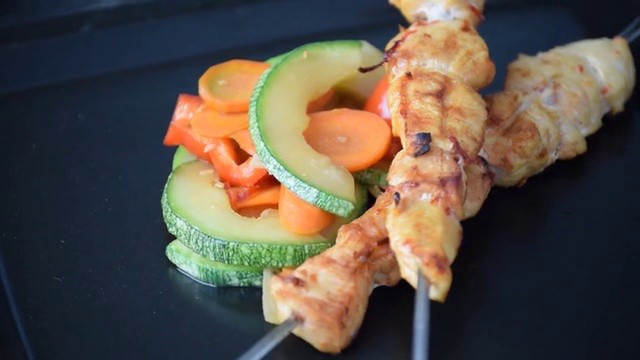

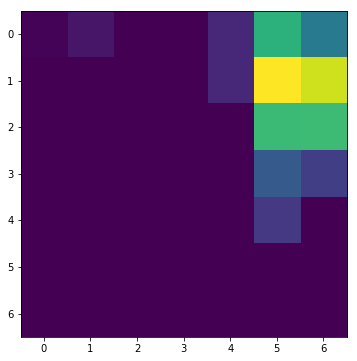

In [22]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html?highlight=convexhull
    
folder='chicken_11679'

img = open_image(cwd+folder+'/frame100.jpg') # fastai Image obj
im = cv2.imread(cwd+folder+'/frame100.jpg')  # np.array


learn_keys = list(v.learners.keys())
learn_doneness,learn_rawfoods = v.learners[learn_keys[0]],v.learners[learn_keys[1]]

gcam = GradCam.from_one_img(learn_doneness,img)

from PIL import Image
tmp = Image.fromarray(im.astype('uint8'), 'RGB') #.shape() 
fig,ax = plt.subplots(figsize=(10,6))
ax.imshow(gcam.hmap1)
img

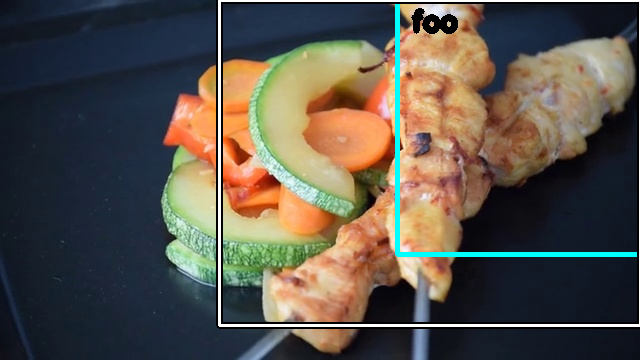

In [0]:

# def frames_to_video(self,path,frames_folder,fname_out,
def frames_to_video(frames_folder,fname_out,
                    pred_dict,
                    fontsz=1,coord=(40,75),color=(255,255,255),thickness=2,
                    fps=10,show_proba=True,threshold=None):
    '''
    converts jpg frames to avi video
    # https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481
    frames_folder : name of folder where jpg frames are stored, str
    fname_out     : file name of output .avi video, str
    pred_dict     : hash of cnn_name: pretrained cnn_leaner,ImageDataBunch
    fontsz        : font size of text overlay, float
    coord         : loc of text overlay, tuple of int
    color         : rgb color, tuple of int
    thickness     : font boldness, int
    fps           : frames per sec, float 
    show_proba    : annotate prediction proba, bool
    threshold     : prediction proba threshold to overlay text, float
    returns       : None
    '''
    t0 = time()
    from os.path import isfile, join

    root,dirs,files = next(os.walk(path+frames_folder))
    # must sort filenames else files in order file0, file1, file 10,..
    files = self.sort_filenames(files)

    print('Reading .jpg frames in: {}'.format(path+frames_folder))

    pathIn= path+frames_folder 
    pathOut = path+fname_out
    fps = fps
    frame_array = []
    file_name_list = [root+'/'+files[i] for i in range(len(files))]
    for i in range(len(file_name_list)):
        img = cv2.imread(file_name_list[i]) # .jpg
        im_arr = np.asarray(img) # convert to np array  

        # add prediction text annotation
        for j,learner_name in enumerate(pred_dict[files[i]]): # dict of dict with learner name key
            pred_result = pred_dict[files[i]][learner_name][0]
            pred_proba,pred_class = pred_result[0],pred_result[1]
            if threshold:
                if pred_proba >= threshold:
                    if show_proba:
                        s='{} {:.3f}'.format(pred_class.upper(),pred_proba)
                    else:    
                        s='{}'.format(pred_class.upper())
                else:
                    s = ''
            else:      
                if show_proba:
                    s='{} {:.3f}'.format(pred_class.upper(),pred_proba)
                else:
                    s='{}'.format(pred_class.upper())

            y_coord = coord[1]+j*35
            coord_adj = (coord[0],y_coord)
            tmp_img = self.overlay_text(im_arr,s,coord=coord_adj,
                                 font=cv2.FONT_HERSHEY_SIMPLEX,
                                 fontsz=fontsz,color=color,thickness=thickness)        
            height, width, layers = tmp_img.shape
            size = (width,height)

        #insert frame into an image array
        frame_array.append(tmp_img)

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

    mins = (time()-t0)/60
    print('\nRuntime: {:.2f} mins'.format(mins))

    print('\n.jpg frames to .avi video conversion complete for images in {}\n'.format(path+frames_folder))

def bbox(learner_name,arr_im,fastai_img,label,
         blur=False,thresh_pad=10,
         rgb=(255,255,0),linewidth=2):
    '''
    compute gradcam saliency map attention (sm) and boundingbox around sm
    learner_name : pretrained cnn object, fastai cnn_learner,
    arr_im       : image pixel data, numpy array
    fastai_img   : image object for gradcam, fastai Image 
    label        : predicted class label from learner, str
    blur         : applies medianBlur to saliency map, bool
    thresh_pad   : adds a scalaer to cv2 binary threshold, int 
    linewidth    : bbox line width, float
    returns      : bounding box coordinates and image array with bounding box
    '''
    # learner = learn_doneness
    # path = cwd+folder+'/frame100.jpg'
    # im = cv2.imread(path) 
    # arr_im = im
    # rgb=(0,255,0)
    # linewidth=2
    # thresh_pad=10
    # blur=False
    # label='foo'
#     fastai_img = open_image(path)  
    # img_pil = Image.fromarray(orig_im.astype('uint8'), 'RGB') 
    # compute gradcam attention/saliency map object
    orig_im = arr_im
    learner = v.learners[learner_name]
    gcam = GradCam.from_one_img(learner,fastai_img)
    # compute heatmap
    hmap = gcam.hmap1  

    # resize reduced heatmap array to match original image 
    dim = orig_im.shape
    xdim,ydim = dim[1],dim[0]
    hmap = cv2.resize(hmap,(xdim,ydim))

    # normalize sm with image
    hnorm = None
    hnorm  = cv2.normalize(hmap,hnorm,alpha=0,beta=255,
                           norm_type=cv2.NORM_MINMAX)
    hnorm  = np.array(hnorm,dtype=np.uint8)
    hnorm = cv2.applyColorMap(hnorm,cv2.COLORMAP_JET)
    if blur:
        hnorm = cv2.medianBlur(hnorm,15)

    # must convert to grayscale before passing data to findContours 
    hnorm_gray = cv2.cvtColor(hnorm,cv2.COLOR_BGR2GRAY)
    # must make it an array
    hnorm_gray = np.array(hnorm_gray,dtype=np.uint8)
    # compute binary threshold array
    min_val = hnorm_gray.min()
    ret,thresh = cv2.threshold(hnorm_gray,min_val+thresh_pad,255,
                               cv2.THRESH_BINARY)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]

    # get rectangle bounding box vertices x,y, width w, height h
    x,y,w,h = cv2.boundingRect(cnt) 
    # draw rectangle on image
    cv2.rectangle(orig_im,(x,y),(x+w,y+h),(0,0,0),linewidth+4) # black background
    cv2.rectangle(orig_im,(x,y),(x+w,y+h),rgb,linewidth) #parameterized foreground
    # cv2_imshow(orig_im)
    return orig_im, (x,y,w,h)

path = cwd+folder+'/frame100.jpg'
img_fastai = open_image(path)  

x,bbox = bbox('nyc_raw_food.pkl',im,img_fastai,'cooked',rgb=(255,255,255))
# x,bbox = bbox('rn34_base_jeff.pkl',im,img_fastai,'cooked')

cv2_imshow(x)
# bbox
# v.learners


### OpenCV Thresholding
First, you may convert to gray-scale, but then you have to consider that grayscale still has at least 255 values. What thresholding can do, at the most basic level, is convert everything to white or black, based on a threshold value. Let's say we want the threshold to be 125 (out of 255), then everything that was 125 and under would be converted to 0, or black, and everything above 125 would be converted to 255, or white. If you convert to grayscale as you normally will, you will get white and black. If you do not convert to grayscale, you will get thresholded pictures, but there will be color

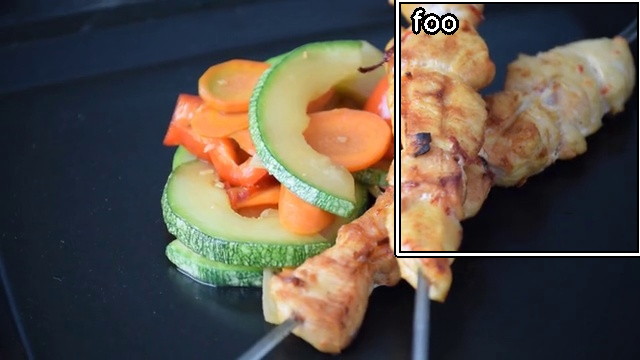

(397, 0, 243, 254)

In [0]:
def overlay_text(img_arr,text_str,coord=(50,75),
                 font=cv2.FONT_HERSHEY_SIMPLEX,
                 fontsz=2,rgb=(255,255,255),thickness=2):
    '''
    overlay text to an image array
    img_arr    : image, np.array
    text_str   : value to write, str
    coord      : loc of text, tuple of int
    font       : cv2 specified font
    fontsz     : fontScale of text, int
    color      : rgb tuple of 3 ints
    thickness  : thickness of font, int
    rgb        : red,green,blue code, tuple of ints
    returns    : image, jpg
    '''
    img = cv2.putText(img_arr,text_str,coord,font,fontsz,(0,0,0),thickness+4) #black background
    img = cv2.putText(img_arr,text_str,coord,font,fontsz,rgb,thickness) # white overlay 
    return img

    
# original image
im = cv2.imread(cwd+folder+'/frame100.jpg') 
# img = cv2.resize(im,(400,300))
# size to larger horizontal
img = cv2.resize(im,(im.shape[1],im.shape[0]))

# hmap = gcam.hmap1

# size heatmap to match original image 

hmap = cv2.resize(gcam.hmap1,(img.shape[1],img.shape[0]))

hmap.shape
hnorm = None
hnorm  = cv2.normalize(hmap,hnorm,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX) #.astype(int)
hnorm  = np.array(hnorm,dtype=np.uint8)
hnorm = cv2.applyColorMap(hnorm,cv2.COLORMAP_JET)


# must convert to grayscale before passing data to findContours 
# ret,thresh = cv2.threshold(img,127,255,0)
hnorm_gray = cv2.cvtColor(hnorm,cv2.COLOR_BGR2GRAY)
# must make it an array
hnorm_gray = np.array(hnorm_gray,dtype=np.uint8)
# hnorm_gray = cv2.medianBlur(hnorm_gray,15)

ret,thresh = cv2.threshold(hnorm_gray,25,255,cv2.THRESH_BINARY)
# hmap_gray = cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY)
im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

# get rectangle bounding box vertices x,y, width w, height h
x,y,w,h = cv2.boundingRect(cnt) #(x,y) top-left, (w,h) width,height, rgb, line width
cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,0),6) # k background
cv2.rectangle(im,(x,y),(x+w,y+h),(255,255,255),2) # rgb overlay
overlay_text(im,'foo',coord=(x+15,y+30),
                 font=cv2.FONT_HERSHEY_SIMPLEX,
                 fontsz=.9,rgb=(0,0,0),thickness=3)
overlay_text(im,'foo',coord=(x+15,y+30),
                 font=cv2.FONT_HERSHEY_SIMPLEX,
                 fontsz=.9,rgb=(255,255,255),thickness=2)
# plt.imshow(im,alpha=1)

cv2_imshow(im)

x,y,w,h